In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl, warnings

In [16]:
exps  = ['exp1','exp2','exp3','exp4']
funcs = ['sphere','rastrigin','rosenbrock']
freq = 10

In [17]:
# funcs
pat = re.compile('.*/(exp\d)/(\w*)/nonn/freq([0-9\.]+)div(\w+)/(\w+)_\w+.csv')
decode_keys = ['experiment','function','freq','div','method']
nn_pat = re.compile('.*/(exp\d)/(\w*)/nn/freq([0-9\.]+)\w+div([A-Za-z]+)/(\w+)_(\w+)_\w+.csv')
nn_decode_keys = ['experiment','function','freq','div','method','replace_mech']

def get_best_knowns():
    best_knowns = (pd.DataFrame(
        {f'{exp}/{func}':pd.read_csv(Path(f'../../data/results/{exp}/{func}/best_known.csv')).fitness.values
         for exp in exps for func in funcs}
    ).melt(value_name='fitness'))
    best_knowns['experiment'] = best_knowns['variable'].str.split('/').apply(lambda x: x[0])
    best_knowns['function'] = best_knowns['variable'].str.split('/').apply(lambda x: x[1])
    return best_knowns.drop('variable', axis=1)

def get_files(m): return list(path.glob(f'**/nonn/**/*{m}.csv'))
def get_nn_files(m): return list(path.glob(f'**/nn/**/*{m}.csv'))

def df_mean(df, m):
#     for n,d in df.groupby(['experiment', 'function', 'freq', 'method']):
#         import pdb;pdb.set_trace()
#     cols = df.columns[:100]
#     means = df.loc[:,cols].mean(axis=1)
#     df[m] = means
#     df.rename({'0': m.upper(), m:m.upper()}, axis=1, inplace=True)
    return df#.drop(cols, axis=1)

def read_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(decode_keys,pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['div']
    df['method'] = df['method'].str.replace('noNNRestart_No', 'noNN_Rst')
    df.drop('div', axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def read_nn_csv(f,m):
    df = pd.read_csv(f)
    df = df.mean().to_frame().T
    for k,v in zip(nn_decode_keys,nn_pat.search(str(f)).groups()): df[k] = v
    df['freq'] = df['freq'].astype(float)
    df['method'] = df['method'] + '_' + df['replace_mech'] + '_' + df['div']
    df['method'] = df['method'].str.replace('NNnorm_Worst', 'NN')
    df.drop(['replace_mech','div'], axis=1, inplace=True)
    df = df_mean(df, m)
    return df

def get_data(m='fitness', normalize=False):
#     short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNN_R':'noNN', 'noNN_RI': 'noNN_RI',
#                   'noNN_Cw':'noNN_Cw','noNN_No':'noNN_No', 'noNN_CwN':'noNN_CwN', 'noNN_CwcN':'noNN_CwcN','noNN_Cwc':'noNN_Cwc',  }
    files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_csv(f,m) for f in files] + [read_nn_csv(f,m) for f in nn_files])
    #data.method = data.method.apply(lambda x: short_dict[x])
#     data = data[data.nnp.isna() | (data.nnp == str(nn_p))].drop('nnp', axis=1)
    if normalize:
        data_norm = (data.groupby(['experiment','function','freq','method'])[m.upper()].mean().reset_index()
                         .groupby(['experiment','function'])[m.upper()].min().reset_index()
                         .rename({m.upper():m.upper()+'_norm'}, axis=1))
        data = data.merge(data_norm, 'left')
        data[m.upper()+'_norm'] = data[m.upper()] / data[m.upper()+'_norm']
    return data.reset_index(drop=True)


def get_data_new(m='fitness', normalize=False):
#     short_dict = {'NNnorm_Random':'NNR', 'NNnorm_Worst':'NNW', 'noNN_R':'noNN', 'noNN_RI': 'noNN_RI',
#                   'noNN_Cw':'noNN_Cw','noNN_No':'noNN_No', 'noNN_CwN':'noNN_CwN', 'noNN_CwcN':'noNN_CwcN','noNN_Cwc':'noNN_Cwc',  }
    files = get_files(m)
    nn_files = get_nn_files(m)
    data = pd.concat([read_csv(f,m) for f in files] + [read_nn_csv(f,m) for f in nn_files])
    return data.reset_index(drop=True)


def plot_one(exp, func, freq, ax, lbl_dict=None):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method if lbl_dict is None else lbl_dict[row.method]
        ax.plot(row[:100].values, label=lbl, linewidth=2, alpha=0.65)
    return ax



path = Path(f'../../data/cluster_results')



In [18]:
best_knowns = get_best_knowns()
data_new = get_data_new()

In [19]:
best_knowns = best_knowns[(best_knowns.experiment=='exp1') & (best_knowns.function=='sphere')]
best_knowns.fitness

0     9.190761e-76
1     2.567461e+02
2     6.359316e+02
3     7.500000e+02
4     7.500000e+02
5     7.500000e+02
6     7.442825e+01
7     1.785031e+02
8     3.514117e-77
9     2.607629e-76
10    9.984325e-01
11    2.672941e-76
12    1.431579e-77
13    3.245044e+00
14    2.055877e+02
15    2.453438e+00
16    1.469701e+00
17    1.114772e+02
18    5.825766e+00
19    2.208480e-75
20    2.543347e+01
21    3.306739e-78
22    1.844376e-76
23    2.521630e-76
24    7.485410e-76
25    2.010021e-76
26    4.077417e-77
27    2.656526e-78
28    2.300461e-76
29    2.611275e+02
          ...     
70    1.973596e+02
71    1.227161e+02
72    3.326895e+01
73    6.962332e-77
74    5.581539e-76
75    1.198558e-77
76    4.926989e-76
77    3.875315e-76
78    1.499979e-76
79    3.002653e-76
80    4.010613e-76
81    2.001239e-76
82    1.698936e-76
83    2.864150e-76
84    1.920930e-77
85    3.127529e-77
86    2.608626e-77
87    2.388548e-78
88    1.992267e-75
89    6.313564e-77
90    2.595206e-75
91    6.7722

In [20]:
data_series = data_new['method']

In [21]:
# data_new = data_new[data_series.str.contains('RI') & (data_new['freq']==10)]

In [22]:
df_final = data_new.sort_values(by='experiment')
df_final['method'].unique()
# df_final.drop('freq', axis=1)

array(['noNN_RI', 'NN_CwN', 'NN_No', 'NN_HMu', 'NN_RI', 'noNN_Rst',
       'noNN_No', 'noNN_CwN', 'noNN_HMu'], dtype=object)

In [24]:
def plot_two(exp, func, freq, div, df_final, ax, lbl_dict=None):
    df_final = df_final[(df_final['experiment']==exp) & (df_final['function']==func) & (df_final['freq']==freq)]
    rows = df_final[df_final['method']==div].iloc[:,:100].values
#     lbl = df_final.method if lbl_dict is None else lbl_dict[row.method]
    ax.plot(rows[0],linewidth=1, alpha=0.65)
    return ax

In [28]:
func='sphere'
exp='exp1'
df_final.method.unique()

array(['noNN_RI', 'NN_CwN', 'NN_No', 'NN_HMu', 'NN_RI', 'noNN_Rst',
       'noNN_No', 'noNN_CwN', 'noNN_HMu'], dtype=object)

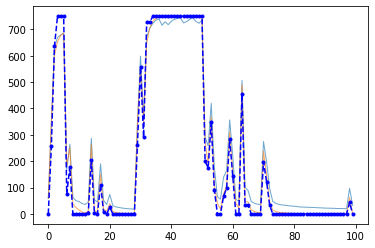

In [31]:
fig, ax = plt.subplots()
plot_two(exp, func, 10,'noNN_CwN', df_final, ax, lbl_dict=None)
plot_two(exp, func, 10,'NN_CwN', df_final, ax, lbl_dict=None)
ax.plot(best_knowns.fitness, 'b.--')
# ax.legend(loc='lower right')

[3.5466031486965567e-20 267.47160442556014 1.0752136228759535
 3.3667118639107164e-22 2.074370577965735e-43 3.526331520364126
 209.31123880414552 2.4675945213679835 1.474119536665283
 114.28525472940613 6.572026378475991 0.8333333333333334 638.2670274117355
 26.52747753372433 0.8333333333333334 0.8333333333333334
 5.4951158273670354e-30 1.693013312336725e-50 1.8369040864217882e-72
 5.250460485366987e-93 1.778557421653773e-114 2.8425612193450033e-136
 268.6793880413751 750.0 560.4361393526193 295.0230768013613
 729.3392858723951 728.1910142719247 750.0 750.0 750.0 750.0 750.0 750.0
 750.0 750.0 750.0 750.0 750.0 750.0 750.0 750.0 750.0 750.0 750.0 750.0
 750.0 275.91799742668644 233.01527244058101 371.53970461542
 114.7562979212601 10.833333333333334 6.666666666666667 71.73761578574405
 98.75421244783226 285.8494236357019 109.81626248864714 144.69770278179828
 0.8333333333333334 7.1704379746402024e-31 458.47283406583375
 36.303279339283755 36.29369579744726 0.8333333333333334
 0.8333333

[79.312814702408 56.0720208472111 24.157244587976678 28.90150457660291
 33.91838048872836 39.71236302221398 45.590637767387044 52.13854942178322
 58.80330516125649 65.5171394344143 72.688549590775 79.7283554514124
 37.2116880172937 88.0865170888514 95.38755746097893 102.94119359746286
 110.53761991693946 116.44942458023964 124.81678159854424
 131.52405415294027 139.09823157330868 146.4215071450056 153.8210838397458
 23.621413290841364 160.44468983278867 167.74992052406762
 175.1390784989677 183.673194927116 191.64965260042035 198.6678229370864
 200.08944691180514 205.88737899508774 209.53589702566885
 214.85564338745672 14.063008790312445 216.6733342295492
 213.60871104004053 215.25949666388485 210.86923573708543
 211.00018096736903 203.51165660515298 195.97132504383288
 198.36361831934425 180.11603460567767 171.09143904200897
 9.806572714130011 156.30097667004523 141.13127005025632
 124.71036827153102 107.84446355768968 86.63639276557916 69.62289340693958
 54.47302762941318 44.8090997

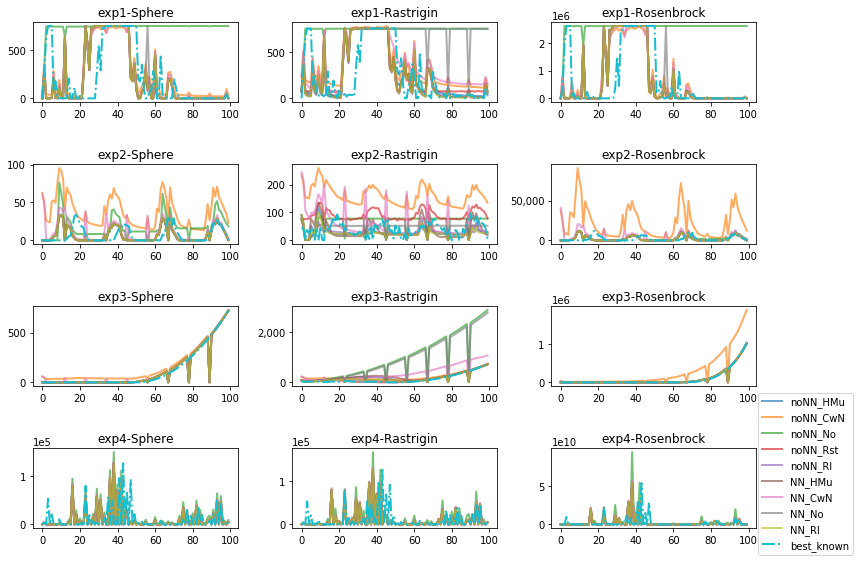

In [269]:
# Plot
fig,axs = plt.subplots(4, 3, figsize=(12,8))#14,6 for only two plot
lbl_dict = {'NNnorm_Worst_fitness' :'NNW',
            'NNnorm_Random_fitness':'NNR',
            'noNNReval_fitness'    :'noNN',
            'best_known'           :'best_known'}
lbl_dict = None

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax, lbl_dict)
        # plot best
        best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
        ax.plot(best_values, lw=2, ls='-.', label='best_known')
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='lower right', bbox_to_anchor=(1.4, -0.4, 0.1, 0.1))# bbox ``(x, y, width, height)``
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

# fig.savefig(f'../../data/cluster_results/fitnessall{freq_lbl}.eps', dpi=400, format='eps')